Nota: Este código ha sido escrito con la ayuda de GitHub Copilot, principalmente las sugerencias de autocompletar.

Importamos las librerías necesarias

In [19]:
import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt

Definimos constantes y otras variables que se emplearan. También se abre los archivos en donde se almacenarán los datos

In [20]:
N = 16
L = 4
h = 0.002
epsilon = 1
sigma = 1
m = 1
v_0 = 0
k=1

skip = 50 # Cada cuantos pasos se guarda la informacion

Time = 600
time = np.arange(0, Time, h)
f = open(f"datos_apartado_7/posiciones_{v_0}.txt", "w")
f_energia = open(f"datos_apartado_7/energias_{v_0}.txt", "w")
f_velocidad = open(f"datos_apartado_7/velocidades_{v_0}.txt", "w")

Definir funciones para el programa:

Notación:
- L, indica la longitud de la caja
- T, tiempo total a calcular
- r, matriz con posiciones de las partículas. Tiene dimensiones (N, 2), con N el número de partículas
- R, matriz con la distancia entre partículas

Comenzamos con las condiciones iniciales, en la función init_cond(), 

In [21]:
@jit(nopython=True)
def init_cond():
    r = np.zeros((N, 2))
    v =np.zeros((N, 2))
    for i in range(N):
        r[i] = np.array([i%4+0.5, i//4 +0.5])
        theta = np.random.rand()*2*np.pi
        v[i] = v_0 * np.array([np.sin(theta), np.cos(theta)])
    return r, v

@jit(nopython=True)
def init_cond_rand():
    r = np.zeros((N, 2))
    v =np.zeros((N, 2))
    for i in range(N):
        r[i] = np.array([i%4+0.5, i//4 +0.5]) + np.random.rand(1, 2)[0]
        theta = np.random.rand()*2*np.pi
        v[i] = v_0 * np.array([np.sin(theta), np.cos(theta)])
    return r, v

@jit(nopython=True)
def cond_contorno(r):
    if(r[0] > L):
        r[0] = r[0] - L
    if(r[0] < 0):
        r[0] = r[0] + L
    if(r[1] > L):
        r[1] = r[1] - L
    if(r[1] < 0):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def cond_contorno_distancia(r):
    if(r[0] > L/2):
        r[0] = r[0] - L
    elif(r[0] < -L/2):
        r[0] = r[0] + L
    if(r[1] > L/2):
        r[1] = r[1] - L
    elif(r[1] < -L/2):
        r[1] = r[1] + L
    return r

@jit(nopython=True)
def lennard_jones(r):
    R = compute_distance(r)
    acc = np.zeros((N, 2))
    for i in range(N):
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                if (norm < 3):
                    acc[i] = acc[i] + 4*R[i, j]* epsilon * (6*np.power((sigma/norm), 5) - 12*np.power((sigma/norm), 11))/(norm*m)
    return acc, R

@jit(nopython=True)
def compute_distance(r):
    R = np.zeros((N, N, 2))
    for i in range(0, N-1):
        for j in range(i+1, N):
            R[i, j] = r[j]- r[i]
            R[i, j] = cond_contorno_distancia(R[i, j])
            R[j, i] = -R[i, j]
    return R

@jit(nopython=True)
def verlet_algorithm(r, v, a):
    w = np.zeros((N, 2))
    for i in range(N):
        r[i] = r[i] + h*v[i] + h*h*a[i]/2
        r[i] = cond_contorno(r[i])
        w[i] = v[i] + h*a[i]/2
    a, R = lennard_jones(r)
    for i in range(N):
        v[i] = w[i] + h*a[i]/2
    return r, v, a, R

@jit(nopython=True)
def compute_energy(v, R):
    T = 0
    V = 0
    for i in range(N):
        T = T + 0.5*m*np.linalg.norm(v[i])**2
        for j in range(N):
            if(i!=j):
                norm  = np.linalg.norm(R[i, j])
                V = V + 4*epsilon * (np.power((sigma/norm), 12) - np.power((sigma/norm), 6))
    return T, V

def compute_average_speed(v):
    v_prom = 0
    for i in range(N):
        v_prom = v_prom + np.linalg.norm(v[i])
    return v_prom/N

def write_vector(r, f):
    for i in range(N):
        f.write(f"{r[i, 0]}, {r[i, 1]}\n")

def write_velocity(v, f):
    for i in range(N):
        f.write(f"{v[i, 0]}, {v[i, 1]}, {np.linalg.norm(v[i])}\n")

@jit(nopython=True)
def compute_mean_square_displacement(r1, r2):
    num = 0
    if len(r1) != len(r2):
        for i in range(len(r1)):
            num = np.linalg.norm(r1[i] - r2)**2
    else:
        for i in range(len(r1)):
            num = np.linalg.norm(r1[i] - r2[i])**2
    return num/(len(r1))


Repetimos el proceso pero variando la temperatura


In [22]:
f = open(f"datos_temp_crit/posiciones_{v_0}.txt", "w")
f_energia = open(f"datos_temp_crit/energias_{v_0}.txt", "w")

T, V = np.zeros(len(time)), np.zeros(len(time))

r, v = init_cond()
write_vector(r, f)
a, R = lennard_jones(r)
T[0], V[0] = compute_energy(v, R)
f_energia.write(f"{T[0]}, {V[0]}\n")

for i in range(1, len(time)):
    r, v, a, R = verlet_algorithm(r, v, a)
    T[i], V[i] = compute_energy(v, R)
    if (time[i]%60 == 0):
        v = v*1.1
    if (i%skip == 0):
        f.write(f"\n")
        write_vector(r, f)
        f_energia.write(f"{T[i]}, {V[i]}\n")

f.close()
f_energia.close()

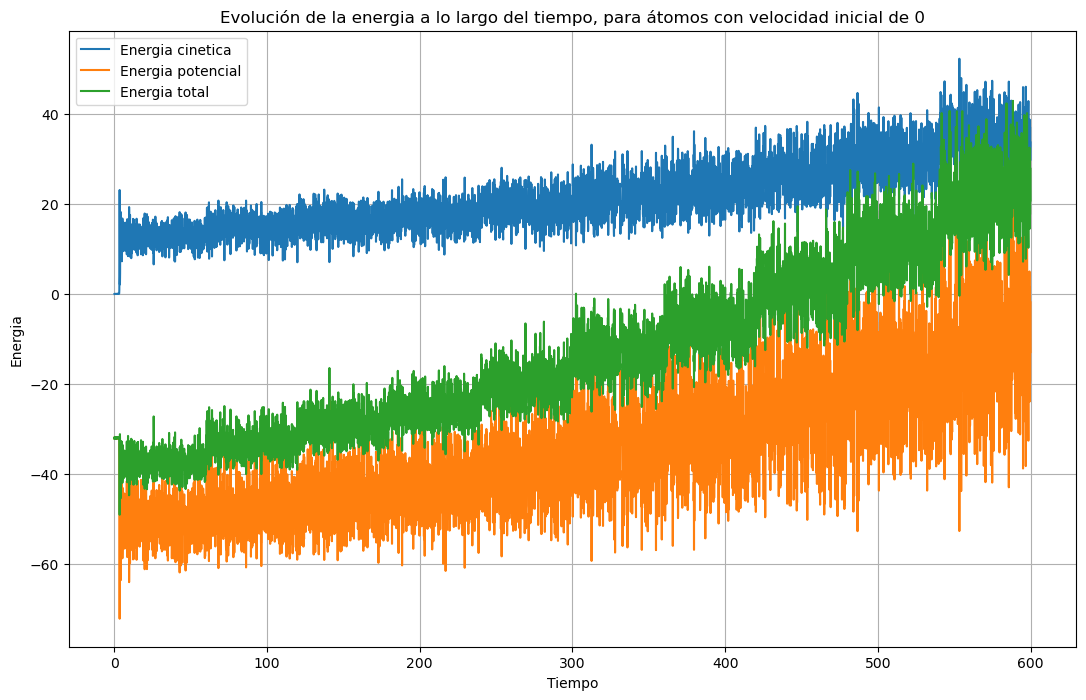

In [23]:
fig=plt.figure(figsize=(13,8)) #Size of the plot
ax=fig.add_subplot(111)

skipped_time = time[::skip]

plt.plot(skipped_time, T[::skip], label="Energia cinetica")
plt.plot(skipped_time, V[::skip], label="Energia potencial")
plt.plot(skipped_time, T[::skip]+V[::skip], label="Energia total")
plt.xlabel("Tiempo")
plt.ylabel("Energia")
plt.legend()
plt.title(f"Evolución de la energia a lo largo del tiempo, para átomos con velocidad inicial de {v_0}")
plt.grid()


Para obtener los desplazamientos cuadrático medio de las partículas, volveremos a leer el archivo creado de las posiciones de las partículas. Para ello emplearemos el código de la animación de los planetas.

In [24]:
file_in = f"datos_temp_crit/posiciones_{v_0}.txt"

# Lectura del fichero de datos
# ========================================
# Lee el fichero a una cadena de texto
with open(file_in, "r") as f:
    data_str = f.read()

# Inicializa la lista con los datos de cada fotograma.
# frames_data[j] contiene los datos del fotograma j-ésimo
frames_data = list()

# Itera sobre los bloques de texto separados por líneas vacías
# (cada bloque corresponde a un instante de tiempo)
for frame_data_str in data_str.split("\n\n"):
    # Inicializa la lista con la posición de cada planeta
    frame_data = list()

    # Itera sobre las líneas del bloque
    # (cada línea da la posición de un planta)
    for planet_pos_str in frame_data_str.split("\n"):
        # Lee la componente x e y de la línea
        planet_pos = np.fromstring(planet_pos_str, sep=",")
        # Si la línea no está vacía, añade planet_pos a la lista de 
        # posiciones del fotograma
        if planet_pos.size > 0:
            frame_data.append(np.fromstring(planet_pos_str, sep=","))

    # Añade los datos de este fotograma a la lista
    frames_data.append(frame_data)

data = np.array(frames_data)


Mediremos el desplazamiento medio cada cierto tiempo para la partícula 0

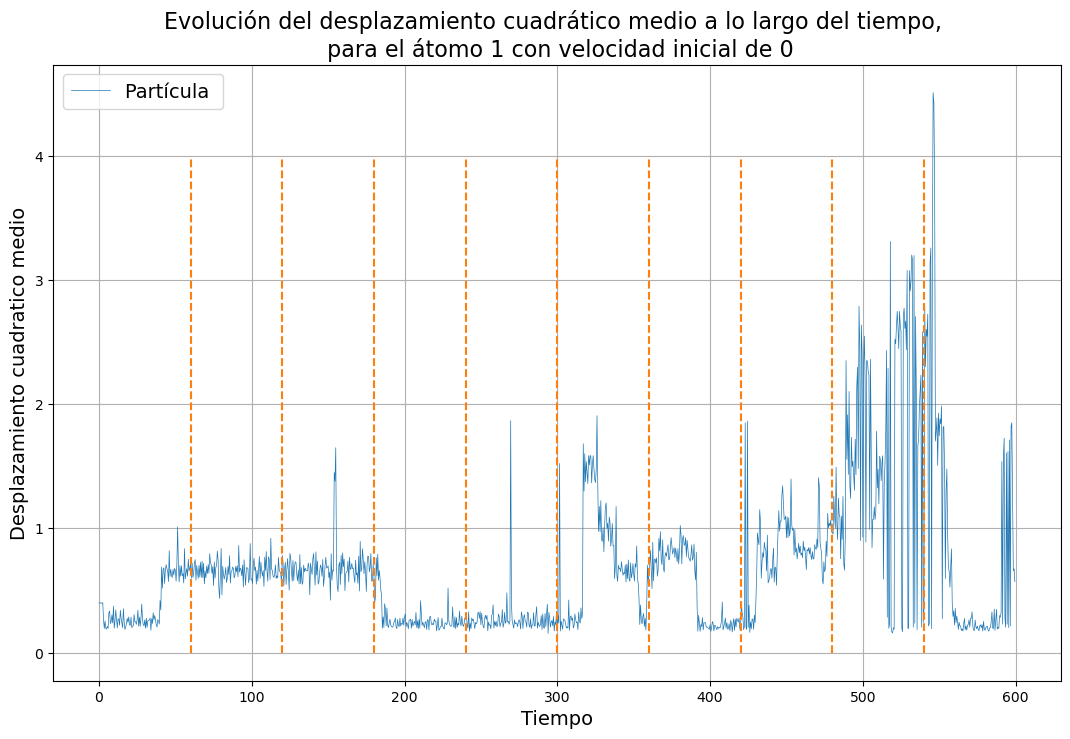

In [44]:
time_between_measurement = 0.01
desplazamiento = np.zeros(int(Time/(time_between_measurement*skip)))
n = int(len(data[:,0])/len(desplazamiento))
for i in range (len(desplazamiento)):
    desplazamiento[i] = compute_mean_square_displacement(data[:,0][i*n:(i+1)*n], data[:,5][i*n:(i+1)*n])

fig=plt.figure(figsize=(13,8))
ax=fig.add_subplot(111)

time_steps = np.arange(0, Time, time_between_measurement*skip)

plt.plot(time_steps, desplazamiento, label=f"Partícula ", lw=0.5)
for i in range(int(Time/60)-1):
    plt.vlines((i+1)*60, 0, 4, color='tab:orange', linestyle='--')
plt.xlabel("Tiempo", fontsize=14)
plt.ylabel("Desplazamiento cuadratico medio", fontsize=14)
plt.legend(fontsize=14)
plt.title("Evolución del desplazamiento cuadrático medio a lo largo del tiempo, \n para el átomo 1 con velocidad inicial de 0", fontsize=16)
plt.grid()

plt.savefig(f"latex/plots/desplazamiento_temp_crit.png")
